# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Function, FunctionSpace
from dolfinx.mesh import create_interval
from constitutive import Phi, sat, temp, D, perm,sign
from mpi4py import MPI
from params import nz,z_f, G,nu,alpha,v_sc
from petsc4py import PETSc
from solvers import solve_pde, time_stepping
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_steady
from post_process import interp
from scipy.interpolate import interp1d
# import sympy as sp

Define domain:

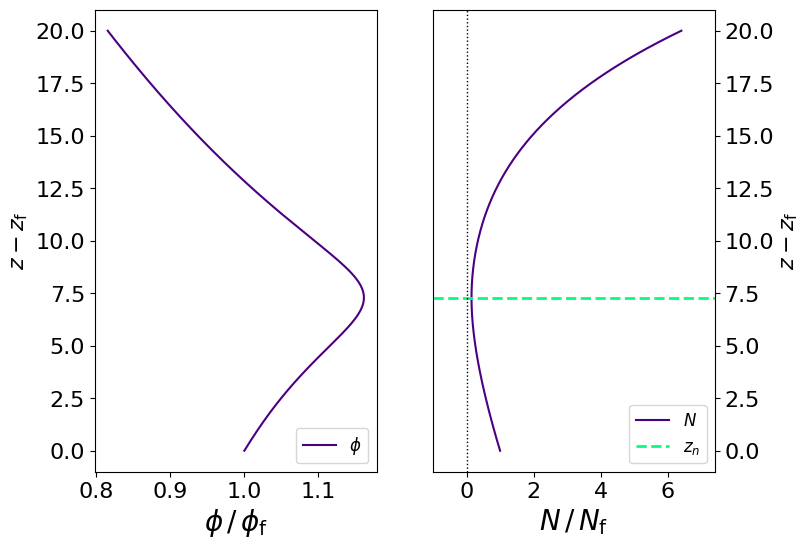

In [3]:
# generate mesh
N_f = 2   #10  # effective stress at base of fringe 
z_l = z_f+20
z_b = z_f+1e-3 #-20
domain = create_interval(MPI.COMM_WORLD,nz,[z_b,z_l])

v_i,dt = 0.0,1.0

V = FunctionSpace(domain, ("CG", 1)) 
# solve quasi-steady problem with regularized diffusivity
initial = Function(V)
initial.interpolate(lambda x: 0.001*(x[0]-z_b)/(z_l-z_b) + N_f)
initial = solve_pde(domain,initial,N_f,v_i,dt,eps=1e-2,penalty=True,steady=True)

# # decrease regularization parameter
eps = np.append(np.flipud(np.logspace(-10,-2,20)),0)
for i in range(eps.size):
    print('eps='+'{:.2e}'.format(eps[i])+' \r',end='')
    initial = solve_pde(domain,initial,N_f,v_i,dt,eps=eps[i],penalty=False,steady=True)

z,N = interp(initial,domain)

plt.close()
%matplotlib inline

plot_steady(N,z)

In [4]:
v_i = 0.01475
timesteps = np.linspace(0,1e4,4000)
N,z,new_lens = time_stepping(domain,initial,N_f,v_i,timesteps,eps=0,penalty=False)

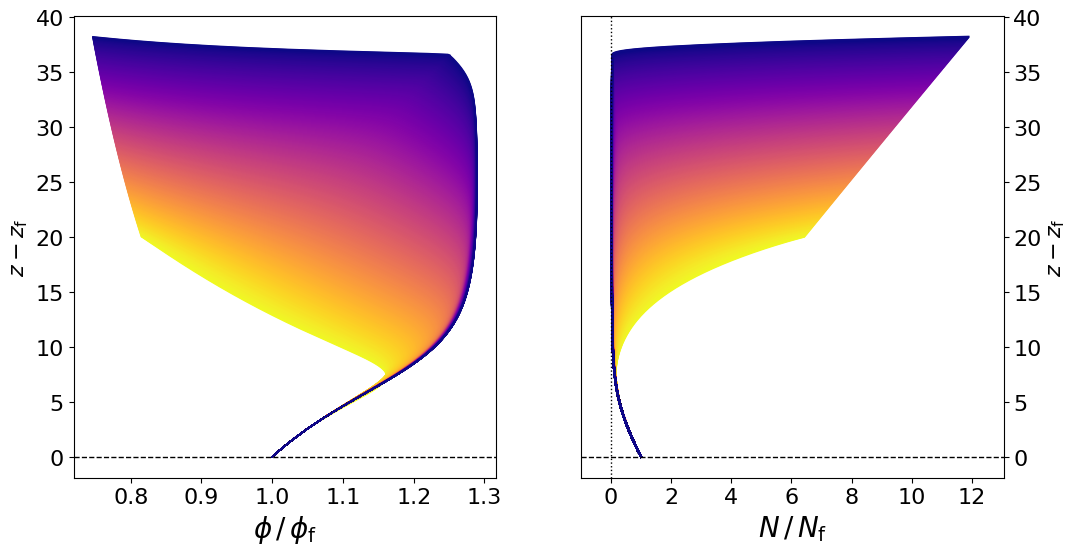

In [5]:
l0 = np.where(new_lens==1)[0][0]
plot(N,z,timesteps[0:l0])

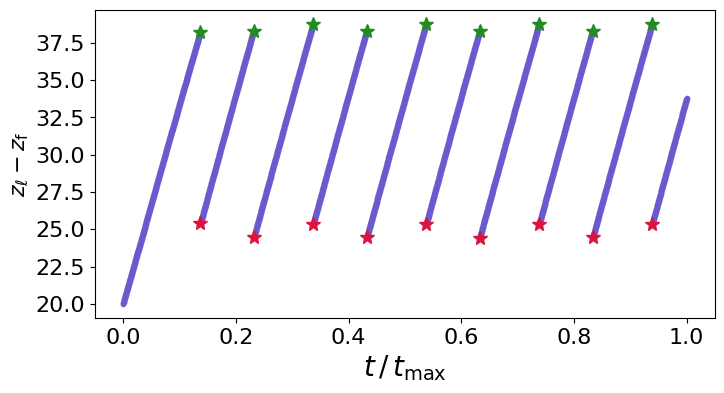

In [6]:
z_l = np.max(z,axis=1)
h = z_l-z_f
old_lens = np.roll(new_lens,-1)

plt.figure(figsize=(8,4))
plt.plot(timesteps/timesteps.max(),h,'o',markersize=3,color='slateblue')
plt.plot(timesteps[new_lens==1]/timesteps.max(),h[new_lens==1],'*',markersize=10,color='crimson')
plt.plot(timesteps[old_lens==1]/timesteps.max(),h[old_lens==1],'*',markersize=10,color='forestgreen')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$z_\ell-z_\mathrm{f}$',fontsize=16)
plt.xlabel(r'$t\,/\,t_\mathrm{max}$',fontsize=20)  
# plt.ylim(2.0,2.2)
plt.show()
plt.close()